# Practica 5. Análisis de Sentimientos
**Tecnologías de Lenguaje Natural**

*Luis Fernando Rodríguez Domínguez*

5BV1

*Ingeniería en Inteligencia Artificial*

Fecha última de modificación: 13 de junio del 2025

## Finalidad del Programa

Este programa en Python, presentado como un Jupyter Notebook, tiene como objetivo principal realizar un análisis comparativo de diferentes enfoques para la clasificación de sentimientos (también conocido como análisis de polaridad) sobre un corpus de reseñas de productos. Para ello, se utiliza el dataset **Amazon Fine Food Reviews** y se aplican diversas técnicas de Procesamiento de Lenguaje Natural (NLP), abarcando metodologías basadas en reglas, aprendizaje de máquina clásico y redes neuronales profundas.

El flujo de trabajo del notebook se estructura de la siguiente manera:

1.  **Adquisición y Exploración de Datos:** Se descarga el dataset desde Kaggle y se realiza un análisis exploratorio para comprender su estructura, dimensiones y características principales.
2.  **Preprocesamiento y Normalización:** Se aplican técnicas de limpieza y preparación de datos, incluyendo la selección de características relevantes, la conversión de calificaciones numéricas a etiquetas de sentimiento categóricas (Positivo, Negativo, Neutral) y el balanceo de clases mediante submuestreo para asegurar un entrenamiento de modelos equitativo.
3.  **Análisis Basado en Diccionarios (Lexicons):** Se emplean léxicos predefinidos como **Opinion Lexicon**, **SentiWordNet** y **Harvard IV-4** para asignar puntuaciones de sentimiento al texto basándose en conteos de palabras con polaridad conocida. Este enfoque no supervisado sirve como un baseline inicial.
4.  **Análisis Basado en Machine Learning Clásico:** Se transforma el texto a representaciones numéricas utilizando la técnica **TF-IDF** y se entrenan clasificadores supervisados clásicos, incluyendo **Regresión Logística**, **Árbol de Decisión** y **Máquinas de Soporte Vectorial (SVM Lineal)**. Su rendimiento se evalúa mediante validación cruzada y métricas en un conjunto de prueba.
5.  **Análisis Basado en Redes Neuronales:** Se explora el poder de los embeddings de palabras. Se implementan y comparan dos estrategias:
    *   Una red neuronal con una capa de **embeddings pre-entrenados (GloVe)**, que aprovecha el conocimiento lingüístico de un corpus masivo.
    *   Una red neuronal que **aprende sus propios embeddings** desde cero, adaptándose específicamente al vocabulario y contexto de las reseñas de alimentos.
6.  **Evaluación y Conclusiones:** Finalmente, se comparan los resultados de todos los modelos de aprendizaje supervisado para determinar qué enfoque ofrece el mejor rendimiento en esta tarea y se extraen conclusiones sobre las ventajas y desventajas de cada metodología.

## Listado y Descripción de Funciones

A continuación, se listan las funciones principales desarrolladas en este notebook, con una breve descripción de su propósito.

*   `set_seed(seed=42)`: Fija las semillas aleatorias para NumPy y TensorFlow para garantizar la reproducibilidad de los resultados.
*   `clasificar_sentimiento(score)`: Convierte una calificación numérica (1-5) a una etiqueta de sentimiento categórica ('Negativo', 'Neutral', 'Positivo').
*   `limpiar_texto_agresivo(texto)`: Realiza una limpieza profunda del texto, incluyendo conversión a minúsculas, y eliminación de URLs, etiquetas HTML, números, puntuación y stopwords, preparándolo para los modelos de ML y NN.
*   `opinion_lexicon_analysis(text)`: Calcula una puntuación de sentimiento para un texto contando las palabras positivas y negativas según el Opinion Lexicon.
*   `get_sentiwordnet_score(text)`: Calcula una puntuación de sentimiento sumando los scores de positividad y negatividad de los synsets de SentiWordNet para las palabras del texto.
*   `harvard_analysis(text)`: Calcula una puntuación de polaridad para un texto utilizando el léxico Harvard IV-4 a través de la librería `pysentiment2`.
*   `build_pretrained_model()`: Construye y compila un modelo de red neuronal secuencial de Keras con una capa de Embedding no entrenable, inicializada con vectores pre-entrenados de GloVe.
*   `build_learned_model()`: Construye y compila un modelo de red neuronal secuencial de Keras con una capa de Embedding entrenable que aprende los vectores de palabras desde cero.
*   `plot_history(history, title)`: Genera gráficos de las curvas de exactitud y pérdida durante el entrenamiento y la validación de un modelo de Keras, a partir de su objeto `history`.


## Detalles y definiciones

### Preparación del entorno

In [1]:
# Librerías de manipulación de datos\import pandas as pd
import numpy as np

# Librerías de visualización
import matplotlib.pyplot as plt
%matplotlib inline

# NLP: Tokenización, stopwords y lexicons
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, opinion_lexicon, sentiwordnet as swn

# ML clásico
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Semillas para reproducibilidad
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()

# Descargar recursos NLTK (si es la primera ejecución)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('opinion_lexicon')
nltk.download('sentiwordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

## 1. Adquisición de Datos

In [2]:
import kagglehub
import os

# --- 1. ADQUISICIÓN DE DATOS ---
print("Descargando el dataset 'Amazon Fine Food Reviews' desde KaggleHub...")

try:
    # Descargar la última versión del dataset
    path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")
    print(f"\n[SUCCESS] Dataset descargado exitosamente.")
    print(f"Ruta a los archivos del dataset: {path}")

    # Verificar si el archivo Reviews.csv existe en la ruta
    csv_file_path = os.path.join(path, 'Reviews.csv')
    if not os.path.exists(csv_file_path):
        print(f"\n[ERROR] El archivo 'Reviews.csv' no se encontró en la ruta de descarga: {csv_file_path}")
        print("Verifica la estructura del dataset descargado.")
        path = None # Invalidar la ruta si el archivo no está
    else:
        print(f"El archivo 'Reviews.csv' fue encontrado en: {csv_file_path}")

except Exception as e:
    print(f"\n[ERROR] Ocurrió un error al descargar el dataset: {e}")
    path = None

Descargando el dataset 'Amazon Fine Food Reviews' desde KaggleHub...

[SUCCESS] Dataset descargado exitosamente.
Ruta a los archivos del dataset: /kaggle/input/amazon-fine-food-reviews
El archivo 'Reviews.csv' fue encontrado en: /kaggle/input/amazon-fine-food-reviews/Reviews.csv


## 2. Análisis exploratorio de datos (EDA)

Esta etapa marca el inicio del Análisis Exploratorio de Datos (EDA). El objetivo es comprender la estructura, contenido y características principales del dataset antes de proceder con el preprocesamiento y el modelado.

1.  **Carga del Dataset:**
    *   Se importa la librería `pandas` para el manejo de DataFrames.
    *   Se utiliza `os.path.join` para construir la ruta completa al archivo `Reviews.csv` usando la variable `path` obtenida anteriormente.
    *   El archivo CSV se carga en un DataFrame de pandas llamado `df`.

2.  **Inspección Inicial:**
    *   Se imprimen las dimensiones (`df.shape`), los nombres de las columnas (`df.columns`) y las primeras filas (`df.head()`) para obtener una vista rápida del formato y contenido.

3.  **Caracterización de Dimensiones:**
    *   Se presenta una tabla en Markdown que resume el propósito, tipo (Nominal/Ordinal) y tipo de dato de cada columna, cumpliendo con los requisitos del EDA de la práctica.

### Dimensiones de Datos Útiles para el Análisis de Sentimiento

Para la tarea de clasificación de sentimientos, las columnas más importantes son:

*   **`Score`**: Contiene la calificación numérica (1 a 5 estrellas). Es la base para generar la etiqueta de sentimiento (Positivo, Neutral, Negativo) que servirá como nuestra variable objetivo (*target*).
*   **`Text`**: Contiene el texto completo de la reseña. Es la característica de entrada principal que los modelos analizarán para predecir el sentimiento.

Las demás columnas (`Id`, `ProductId`, `Summary`, etc.) no son directamente necesarias para esta tarea y podrán ser descartadas.

In [3]:
import pandas as pd

if path:
    csv_file_path = os.path.join(path, 'Reviews.csv')
    print(f"Cargando el dataset desde: {csv_file_path}...\n")
    df = pd.read_csv(csv_file_path)

    # Mostrar dimensiones y columnas
    print("--- Inspección Inicial del Dataset ---")
    print(f"Dimensiones del dataset: {df.shape[0]} filas y {df.shape[1]} columnas.")
    print("\nNombres de las columnas:", df.columns.tolist())
    print("\n--- Primeras 3 filas del dataset: ---")
    display(df.head(3))

    # Caracterizar dimensiones relevantes
    print("\n--- Caracterización de las Dimensiones ---")
    for col in df.columns:
        print(f"Columna: '{col}', Tipo de Dato: {df[col].dtype}, Valores Únicos: {df[col].nunique()}")
else:
    print("[ERROR] No se puede realizar el EDA porque la ruta del dataset no es válida.")


Cargando el dataset desde: /kaggle/input/amazon-fine-food-reviews/Reviews.csv...

--- Inspección Inicial del Dataset ---
Dimensiones del dataset: 568454 filas y 10 columnas.

Nombres de las columnas: ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']

--- Primeras 3 filas del dataset: ---


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...



--- Caracterización de las Dimensiones ---
Columna: 'Id', Tipo de Dato: int64, Valores Únicos: 568454
Columna: 'ProductId', Tipo de Dato: object, Valores Únicos: 74258
Columna: 'UserId', Tipo de Dato: object, Valores Únicos: 256059
Columna: 'ProfileName', Tipo de Dato: object, Valores Únicos: 218415
Columna: 'HelpfulnessNumerator', Tipo de Dato: int64, Valores Únicos: 231
Columna: 'HelpfulnessDenominator', Tipo de Dato: int64, Valores Únicos: 234
Columna: 'Score', Tipo de Dato: int64, Valores Únicos: 5
Columna: 'Time', Tipo de Dato: int64, Valores Únicos: 3168
Columna: 'Summary', Tipo de Dato: object, Valores Únicos: 295742
Columna: 'Text', Tipo de Dato: object, Valores Únicos: 393579


## 3. Preprocesamiento

Esta etapa es crucial para preparar los datos brutos y hacerlos adecuados para los modelos de análisis. Se realizan varias transformaciones para limpiar y estructurar el conjunto de datos.

1.  **Selección y Limpieza de Columnas:**
    *   Se seleccionan únicamente las columnas `Score` y `Text`.
    *   Se eliminan (`dropna()`) las filas con valores nulos para asegurar que cada entrada tenga una calificación y un texto.

2.  **Creación de la Columna de Sentimiento:**
    *   Se define la función `clasificar_sentimiento` que mapea el `Score` a una categoría textual (Negativo, Neutral, Positivo).
    *   Se aplica esta función para crear la nueva columna `Sentimiento`.

3.  **Validación y Balanceo de Clases:**
    *   Se verifica la distribución de las nuevas clases de sentimiento usando `value_counts()`. Se observa un fuerte desbalance, con una mayoría de reseñas 'Positivo'.
    *   Para mitigar el sesgo que esto podría causar en los modelos, se aplica una técnica de **submuestreo (undersampling)**. Se reduce el número de ejemplos de las clases mayoritarias para que coincida con el número de ejemplos de la clase minoritaria ('Neutral').
    *   Esto resulta en un DataFrame balanceado (`df_balanceado`) donde cada categoría de sentimiento tiene el mismo número de muestras, lo cual es ideal para el entrenamiento de modelos de clasificación.


In [4]:
if 'df' in locals():
    # a. Mantener solo las columnas relevantes y eliminar nulos
    print("Seleccionando columnas 'Score' y 'Text' y eliminando filas con valores nulos...")
    relevant_columns = ['Score', 'Text']
    df_proc = df[relevant_columns].dropna().copy()
    print(f"Dimensiones después de seleccionar y limpiar nulos: {df_proc.shape}")

    # b. Crear columna de sentimiento
    def clasificar_sentimiento(score):
        if score <= 2:
            return 'Negativo'
        elif score == 3:
            return 'Neutral'
        else:
            return 'Positivo'

    # c. Aplicar conversión de score a sentimiento
    print("\nCreando la columna 'Sentimiento' a partir de 'Score'...")
    df_proc['Sentimiento'] = df_proc['Score'].apply(clasificar_sentimiento)

    # d. Validar balance de clases
    print("\n--- Distribución de Clases Original (después de crear sentimiento) ---")
    print(df_proc['Sentimiento'].value_counts())
    print("\nSe observa un fuerte desbalance de clases, con una mayoría de reseñas positivas.")

    # Balanceo por submuestreo (undersampling)
    print("\nBalanceando clases mediante submuestreo...")
    min_count = df_proc['Sentimiento'].value_counts().min()
    df_balanceado = df_proc.groupby('Sentimiento').sample(n=min_count, random_state=42)

    print("\n--- Distribución de Clases Después del Balanceo ---")
    print(f"Cada clase tendrá {min_count} muestras.")
    print(df_balanceado['Sentimiento'].value_counts())
    print(f"\nDimensiones del DataFrame balanceado: {df_balanceado.shape}")
else:
    print("[ERROR] El DataFrame 'df' no está definido. Ejecuta la celda de EDA primero.")

Seleccionando columnas 'Score' y 'Text' y eliminando filas con valores nulos...
Dimensiones después de seleccionar y limpiar nulos: (568454, 2)

Creando la columna 'Sentimiento' a partir de 'Score'...

--- Distribución de Clases Original (después de crear sentimiento) ---
Sentimiento
Positivo    443777
Negativo     82037
Neutral      42640
Name: count, dtype: int64

Se observa un fuerte desbalance de clases, con una mayoría de reseñas positivas.

Balanceando clases mediante submuestreo...

--- Distribución de Clases Después del Balanceo ---
Cada clase tendrá 42640 muestras.
Sentimiento
Negativo    42640
Neutral     42640
Positivo    42640
Name: count, dtype: int64

Dimensiones del DataFrame balanceado: (127920, 3)


## 4. Normalización de Datos

La normalización de texto es un paso esencial para estandarizar el texto crudo, reduciendo la variabilidad y el ruido para mejorar el rendimiento de los modelos.

### Justificación de las Técnicas

Dependiendo del modelo a utilizar, la estrategia de normalización varía:

*   **Para Análisis Basado en Diccionarios:** Estos métodos se basan en la coincidencia de palabras exactas. Es útil una limpieza básica (minúsculas, eliminar puntuación), pero **no se deben eliminar las stopwords**, ya que palabras como "not" son cruciales para determinar la negación y el sentimiento. Para este enfoque, aplicaremos las funciones de análisis directamente sobre el texto original o ligeramente procesado.
*   **Para Machine Learning Clásico y Redes Neuronales:** Para estos modelos, es beneficioso un preprocesamiento más agresivo para reducir la dimensionalidad y el ruido. Las técnicas incluyen:
    *   **Conversión a Minúsculas:** Asegura que "Good" y "good" se traten como la misma palabra.
    *   **Eliminación de URLs y Números:** Rara vez aportan información sentimental.
    *   **Eliminación de Puntuación:** Simplifica el texto al enfocarse en las palabras.
    *   **Eliminación de Stopwords:** Palabras muy comunes (the, is, a) que no suelen llevar carga sentimental y aumentan el ruido.

### Implementación

Se define una función `limpiar_texto_agresivo` que encapsula las técnicas para los modelos de ML y NN. Esta función se aplicará más adelante para crear una columna de texto limpio (`Text_cleaned`) que se usará para el entrenamiento de estos modelos. Los métodos basados en diccionario se aplicarán sobre la columna `Text` original.


In [5]:
try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("Descargando recursos adicionales de NLTK (stopwords, punkt)...")
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)

# Cargar stopwords en inglés
stop_words = set(stopwords.words('english'))

def limpiar_texto_agresivo(texto):
    """
    Función de limpieza de texto para modelos de ML y NN.
    Incluye: minúsculas, eliminación de URLs, números, puntuación y stopwords.
    """
    if not isinstance(texto, str):
        return ""
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar URLs
    texto = re.sub(r'http\S+|www\.\S+', '', texto)
    # Eliminar etiquetas HTML
    texto = re.sub(r'<.*?>', '', texto)
    # Eliminar números
    texto = re.sub(r'\d+', '', texto)
    # Eliminar puntuación (mantener solo letras y espacios)
    texto = re.sub(r'[^a-z\s]', '', texto)
    # Eliminar stopwords
    tokens = texto.split()
    tokens = [word for word in tokens if word not in stop_words]
    texto = ' '.join(tokens)
    # Eliminar espacios extra
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

print("Función 'limpiar_texto_agresivo' definida.")
print("Esta función se aplicará más adelante para crear una columna de texto limpio para los modelos de ML y NN.")
print("Los métodos de diccionario se aplicarán sobre el texto original para no perder información contextual como las negaciones.")


Función 'limpiar_texto_agresivo' definida.
Esta función se aplicará más adelante para crear una columna de texto limpio para los modelos de ML y NN.
Los métodos de diccionario se aplicarán sobre el texto original para no perder información contextual como las negaciones.


In [15]:

print("Ejemplo de texto post-normalización:")
texto_ejemplo = "This review is NOT good at all! It cost $10.00. Check out my blog at http://my-reviews.com 😭"
texto_limpio = limpiar_texto_agresivo(texto_ejemplo)
print(f"Texto original: '{texto_ejemplo}'")
print(f"Texto normalizado (limpieza agresiva): '{texto_limpio}'")

Ejemplo de texto post-normalización:
Texto original: 'This review is NOT good at all! It cost $10.00. Check out my blog at http://my-reviews.com 😭'
Texto normalizado (limpieza agresiva): 'review good cost check blog'


## 5. Análisis de Sentimientos con Diccionarios (Lexicons)

Este enfoque utiliza listas de palabras (léxicos) a las que se les ha asignado previamente una polaridad (positiva o negativa). No requiere entrenamiento, ya que se basa en reglas y conteo de palabras.

Se aplicarán tres léxicos diferentes al texto original de las reseñas:

1.  **Opinion Lexicon (NLTK):** Un léxico simple con listas de palabras positivas y negativas.
2.  **SentiWordNet (NLTK):** Asigna a cada synset (conjunto de sinónimos) de WordNet una puntuación de positividad, negatividad y objetividad.
3.  **Harvard IV-4 (pysentiment2):** Un léxico desarrollado en Harvard, orientado a textos de ciencias sociales y finanzas.

Para cada léxico, se calcula un score (puntuaciones positivas - negativas) y se clasifica el sentimiento como 'Positivo' (score > 0), 'Negativo' (score < 0) o 'Neutral' (score = 0).

In [6]:
print("Instalando y descargando recursos para el análisis con diccionarios...")
!pip install -q pysentiment2

import nltk
from nltk.corpus import opinion_lexicon, sentiwordnet as swn, wordnet as wn
from nltk.tokenize import word_tokenize
import pysentiment2 as ps
import re
from nltk.corpus import stopwords


# Descargar recursos de NLTK para los léxicos
nltk.download('opinion_lexicon', quiet=True)
nltk.download('sentiwordnet', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

print("Recursos listos.\n")

if 'df_balanceado' in locals():
    # --- a. Opinion Lexicon ---
    print("--- Aplicando Opinion Lexicon ---")
    positive_words = set(opinion_lexicon.positive())
    negative_words = set(opinion_lexicon.negative())

    def opinion_lexicon_analysis(text):
        tokens = word_tokenize(text.lower())
        pos_count = sum(1 for word in tokens if word in positive_words)
        neg_count = sum(1 for word in tokens if word in negative_words)
        return pos_count - neg_count

    df_balanceado['OL_Score'] = df_balanceado['Text'].apply(opinion_lexicon_analysis)
    df_balanceado['OL_Sentimiento'] = df_balanceado['OL_Score'].apply(lambda score: 'Positivo' if score > 0 else ('Negativo' if score < 0 else 'Neutral'))

    print("Conteo de Clasificaciones (Opinion Lexicon):")
    print(df_balanceado['OL_Sentimiento'].value_counts())
    print("-" * 50)

    # --- b. SentiWordNet ---
    print("\n--- Aplicando SentiWordNet ---")
    def get_sentiwordnet_score(text):
        tokens = word_tokenize(text.lower())
        pos_score, neg_score = 0.0, 0.0
        for word in tokens:
            synsets = wn.synsets(word)
            if synsets:
                try:
                    swn_synset = swn.senti_synset(synsets[0].name())
                    pos_score += swn_synset.pos_score()
                    neg_score += swn_synset.neg_score()
                except:
                    pass
        return pos_score - neg_score

    df_balanceado['SWN_Score'] = df_balanceado['Text'].apply(get_sentiwordnet_score)
    df_balanceado['SWN_Sentimiento'] = df_balanceado['SWN_Score'].apply(lambda score: 'Positivo' if score > 0 else ('Negativo' if score < 0 else 'Neutral'))

    print("Conteo de Clasificaciones (SentiWordNet):")
    print(df_balanceado['SWN_Sentimiento'].value_counts())
    print("-" * 50)

    # --- c. Harvard IV-4 ---
    print("\n--- Aplicando Harvard IV-4 ---")
    harvard = ps.HIV4()
    def harvard_analysis(text):
        tokens = word_tokenize(text.lower())
        score_dict = harvard.get_score(tokens)
        return score_dict.get('Polarity', 0.0)

    # pysentiment2 calcula una polaridad normalizada. La usaremos directamente.
    df_balanceado['HV_Score'] = df_balanceado['Text'].apply(harvard_analysis)
    df_balanceado['HV_Sentimiento'] = df_balanceado['HV_Score'].apply(lambda score: 'Positivo' if score > 0 else ('Negativo' if score < 0 else 'Neutral'))

    print("Conteo de Clasificaciones (Harvard IV-4):")
    print(df_balanceado['HV_Sentimiento'].value_counts())
    print("-" * 50)

    # --- Aplicar limpieza agresiva para las siguientes etapas ---
    print("\nCreando la columna 'Text_cleaned' para los modelos de Machine Learning y Redes Neuronales...")
    df_balanceado['Text_cleaned'] = df_balanceado['Text'].apply(limpiar_texto_agresivo)
    print("Columna 'Text_cleaned' creada.")

    print("\n--- Ejemplo de Texto Original vs. Texto Limpio ---")
    print("Texto Original:", df_balanceado.iloc[0]['Text'])
    print("Texto Limpio:", df_balanceado.iloc[0]['Text_cleaned'])

else:
    print("[ERROR] El DataFrame 'df_balanceado' no está definido.")

Instalando y descargando recursos para el análisis con diccionarios...
Recursos listos.

--- Aplicando Opinion Lexicon ---
Conteo de Clasificaciones (Opinion Lexicon):
OL_Sentimiento
Positivo    87229
Negativo    24637
Neutral     16054
Name: count, dtype: int64
--------------------------------------------------

--- Aplicando SentiWordNet ---
Conteo de Clasificaciones (SentiWordNet):
SWN_Sentimiento
Positivo    87761
Negativo    36087
Neutral      4072
Name: count, dtype: int64
--------------------------------------------------

--- Aplicando Harvard IV-4 ---
Conteo de Clasificaciones (Harvard IV-4):
HV_Sentimiento
Positivo    87284
Neutral     21652
Negativo    18984
Name: count, dtype: int64
--------------------------------------------------

Creando la columna 'Text_cleaned' para los modelos de Machine Learning y Redes Neuronales...
Columna 'Text_cleaned' creada.

--- Ejemplo de Texto Original vs. Texto Limpio ---
Texto Original: I have an absolute passion for deep, dark hot chocol

In [7]:
# prompt: Sacar estadisticas de accuracy, y demás para verificar qué tan bien funcionaron lexicon sentiwordnet y hardvard

import pysentiment2 as ps

# Mapping for classification reports
sentiment_mapping = {'Negativo': 0, 'Neutral': 1, 'Positivo': 2}
y_true = df_balanceado['Sentimiento'].map(sentiment_mapping)

# Evaluate Opinion Lexicon
print("\n--- Evaluación de Opinion Lexicon ---")
y_pred_ol = df_balanceado['OL_Sentimiento'].map(sentiment_mapping)
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred_ol, target_names=['Negativo', 'Neutral', 'Positivo']))
print("Accuracy:", accuracy_score(y_true, y_pred_ol))
print("Matriz de Confusión:")
print(confusion_matrix(y_true, y_pred_ol))

# Evaluate SentiWordNet
print("\n--- Evaluación de SentiWordNet ---")
y_pred_swn = df_balanceado['SWN_Sentimiento'].map(sentiment_mapping)
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred_swn, target_names=['Negativo', 'Neutral', 'Positivo']))
print("Accuracy:", accuracy_score(y_true, y_pred_swn))
print("Matriz de Confusión:")
print(confusion_matrix(y_true, y_pred_swn))

# Evaluate Harvard IV-4
print("\n--- Evaluación de Harvard IV-4 ---")
y_pred_hv = df_balanceado['HV_Sentimiento'].map(sentiment_mapping)
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred_hv, target_names=['Negativo', 'Neutral', 'Positivo']))
print("Accuracy:", accuracy_score(y_true, y_pred_hv))
print("Matriz de Confusión:")
print(confusion_matrix(y_true, y_pred_hv))



--- Evaluación de Opinion Lexicon ---
Reporte de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.64      0.37      0.47     42640
     Neutral       0.34      0.13      0.18     42640
    Positivo       0.43      0.87      0.57     42640

    accuracy                           0.46    127920
   macro avg       0.47      0.46      0.41    127920
weighted avg       0.47      0.46      0.41    127920

Accuracy: 0.4554799874921826
Matriz de Confusión:
[[15678  7493 19469]
 [ 6705  5381 30554]
 [ 2254  3180 37206]]

--- Evaluación de SentiWordNet ---
Reporte de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.50      0.42      0.46     42640
     Neutral       0.34      0.03      0.06     42640
    Positivo       0.41      0.84      0.55     42640

    accuracy                           0.43    127920
   macro avg       0.42      0.43      0.36    127920
weighted avg       0.42      0.43      0.36    12792

##6. Análisis de Sentimientos con Machine Learning

Este apaaaaawdaaassartado implementa un enfoque de Machine Learning tradicional. Se utilizan algoritmos supervisados clásicos entrenados sobre una representación numérica del texto para predecir el sentimiento.

1.  **Vectorización TF-IDF:** El texto limpio (`Text_cleaned`) se convierte a un formato numérico usando **TF-IDF (Term Frequency-Inverse Document Frequency)**. Esta técnica asigna un peso a cada palabra en función de su frecuencia en un documento y su rareza en todo el corpus, lo que ayuda a resaltar términos importantes.
2.  **División de Datos:** El dataset se divide en un conjunto de entrenamiento (80%) y uno de prueba (20%).
3.  **Definición y Evaluación de Modelos:** Se evalúan tres modelos:
    *   **Regresión Logística:** Un modelo lineal simple y efectivo.
    *   **Árbol de Decisión:** Un modelo no lineal basado en reglas.
    *   **Máquinas de Soporte Vectorial (Lineal):** Un clasificador potente, especialmente eficaz en espacios de alta dimensionalidad como los generados por TF-IDF.
4.  **Validación Cruzada:** Se utiliza validación cruzada de 5 pliegues (5-fold cross-validation) en el conjunto de entrenamiento para obtener una estimación más robusta del rendimiento de cada modelo.
5.  **Evaluación Final:** Tras la validación, cada modelo se entrena en todo el conjunto de entrenamiento y se evalúa en el conjunto de prueba, que no ha visto antes. Se reporta la exactitud y un informe de clasificación detallado (precisión, recall, f1-score) para cada clase.

In [8]:
import pickle

if 'df_balanceado' in locals():
    print("--- Preparando datos para modelos de Machine Learning ---")
    # Usar la columna de texto limpio para ML
    X = df_balanceado['Text_cleaned']
    y = df_balanceado['Sentimiento']

    # a. Vectorización TF-IDF
    print("Vectorizando texto con TF-IDF (max_features=5000)...")
    vectorizer = TfidfVectorizer(max_features=5000)
    X_vectorized = vectorizer.fit_transform(X)

    # b. División en entrenamiento y prueba (80/20)
    print("Realizando división train-test (80/20)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_vectorized, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
    print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

    # c. Definición y Evaluación de Modelos
    models = {
        'Regresión Logística': LogisticRegression(max_iter=1000, random_state=42),
        'Árbol de Decisión': DecisionTreeClassifier(random_state=42),
        'Linear SVM': LinearSVC(max_iter=2000, random_state=42)
    }

    target_names = sorted(y.unique())
    results_ml = {}

    for name, model in models.items():
        print(f"\n--- Evaluando Modelo: {name} ---")

        # Validación cruzada (5-fold) sobre el conjunto de entrenamiento
        print("Realizando validación cruzada (5-fold)...")
        try:
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
            print(f"  Exactitud (Accuracy) Media en CV: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")
        except Exception as e:
            print(f"  Error durante la validación cruzada para {name}: {e}")
            continue

        # Entrenar en el conjunto completo de entrenamiento y evaluar en prueba
        print("Entrenando en el conjunto de entrenamiento completo...")
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        test_accuracy = accuracy_score(y_test, preds)
        results_ml[name] = test_accuracy

        print("\nEvaluando en el conjunto de prueba...")
        print(f"  Exactitud (Accuracy) en Prueba: {test_accuracy:.4f}")
        print("  Reporte de Clasificación en Prueba:")
        print(classification_report(y_test, preds, target_names=target_names))

    # Guardar modelos entrenados
    print("\nGuardando modelos de ML entrenados en 'models_ml.pkl'...")
    try:
        with open('models_ml.pkl', 'wb') as f:
            pickle.dump(models, f)
        print("[SUCCESS] Modelos guardados.")
    except Exception as e:
        print(f"[ERROR] No se pudieron guardar los modelos: {e}")
else:
    print("[ERROR] El DataFrame 'df_balanceado' no está definido.")

--- Preparando datos para modelos de Machine Learning ---
Vectorizando texto con TF-IDF (max_features=5000)...
Realizando división train-test (80/20)...
Tamaño del conjunto de entrenamiento: 102336 muestras
Tamaño del conjunto de prueba: 25584 muestras

--- Evaluando Modelo: Regresión Logística ---
Realizando validación cruzada (5-fold)...
  Exactitud (Accuracy) Media en CV: 0.7192 (+/- 0.0027)
Entrenando en el conjunto de entrenamiento completo...

Evaluando en el conjunto de prueba...
  Exactitud (Accuracy) en Prueba: 0.7215
  Reporte de Clasificación en Prueba:
              precision    recall  f1-score   support

    Negativo       0.73      0.73      0.73      8528
     Neutral       0.65      0.65      0.65      8528
    Positivo       0.78      0.79      0.79      8528

    accuracy                           0.72     25584
   macro avg       0.72      0.72      0.72     25584
weighted avg       0.72      0.72      0.72     25584


--- Evaluando Modelo: Árbol de Decisión ---
Rea

## 7. Análisis de Sentimientos con Redes Neuronales

Esta sección utiliza modelos de redes neuronales, que pueden capturar patrones más complejos en los datos. Se exploran dos estrategias para la representación de palabras (embeddings):

1.  **Embeddings Pre-entrenados (GloVe):** Se utiliza una capa de embeddings inicializada con vectores de palabras de GloVe (`glove.6B.100d.txt`). Estos vectores han sido entrenados en un corpus masivo (Wikipedia, Gigaword) y capturan relaciones semánticas generales. La capa de embedding se mantiene "congelada" (`trainable=False`), de modo que el modelo aprovecha este conocimiento externo sin modificarlo.

2.  **Embeddings Aprendidos:** Se utiliza una capa de embeddings que se inicializa aleatoriamente y cuyos pesos (los vectores de palabras) se aprenden desde cero durante el entrenamiento, específicamente a partir de los datos de las reseñas. Esto permite que el modelo genere representaciones adaptadas al dominio y vocabulario específico de las reseñas de alimentos.

Para ambas estrategias, se sigue un proceso similar:
*   **Preparación de Datos:** El texto se convierte en secuencias de enteros y se rellena (padding) a una longitud fija. Las etiquetas de sentimiento se convierten a formato one-hot.
*   **División de Datos:** Se realiza la división 80/20 en entrenamiento y prueba.
*   **Validación Cruzada (K-Fold):** Se aplica validación cruzada de 5 pliegues en el conjunto de entrenamiento para evaluar la robustez de cada arquitectura.
*   **Entrenamiento y Evaluación Final:** Se entrena un modelo final con todos los datos de entrenamiento y se evalúa su rendimiento en el conjunto de prueba. Se utiliza `EarlyStopping` para detener el entrenamiento si el rendimiento en un subconjunto de validación no mejora, previniendo el sobreajuste.
*   **Visualización:** Se grafican las curvas de exactitud y pérdida durante el entrenamiento para analizar el comportamiento del modelo.


--- Preparando datos para Redes Neuronales ---
Tokenizando y creando secuencias de texto...
Realizando división train-test (80/20)...

--- Iniciando Análisis con Embeddings Preentrenados (GloVe) ---
Cargados 400000 vectores de GloVe.

Iniciando Validación Cruzada K-Fold (Pretrained)...
--- Fold 1/5 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


--- Fold 2/5 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


--- Fold 3/5 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


--- Fold 4/5 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


--- Fold 5/5 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Exactitud Media en CV (Pretrained): 0.6315

Entrenando modelo final (Pretrained)...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Exactitud en Prueba (Pretrained): 0.6380

--- Iniciando Análisis con Embeddings Aprendidos ---

Iniciando Validación Cruzada K-Fold (Learned)...
--- Fold 1/5 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


--- Fold 2/5 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


--- Fold 3/5 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


--- Fold 4/5 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


--- Fold 5/5 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Exactitud Media en CV (Learned): 0.7206

Entrenando modelo final (Learned)...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Exactitud en Prueba (Learned): 0.7239

--- Curvas de Entrenamiento (Embeddings Pre-entrenados GloVe) ---


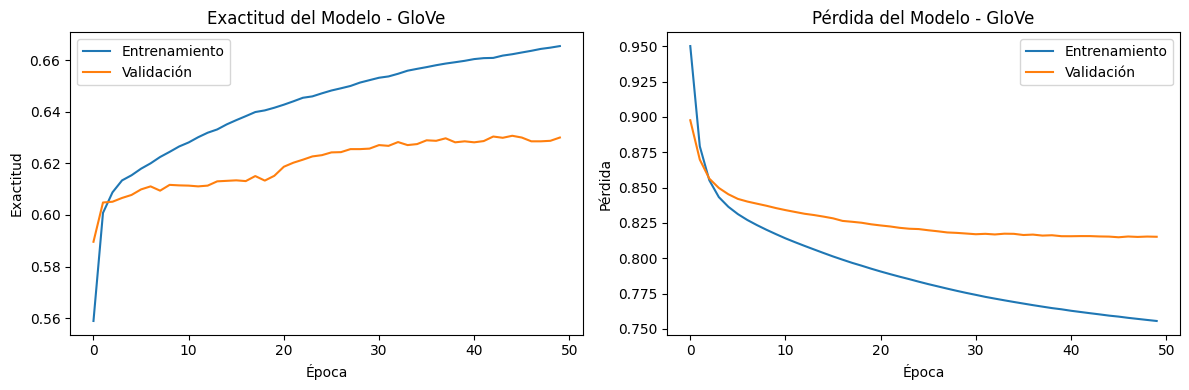


--- Curvas de Entrenamiento (Embeddings Aprendidos) ---


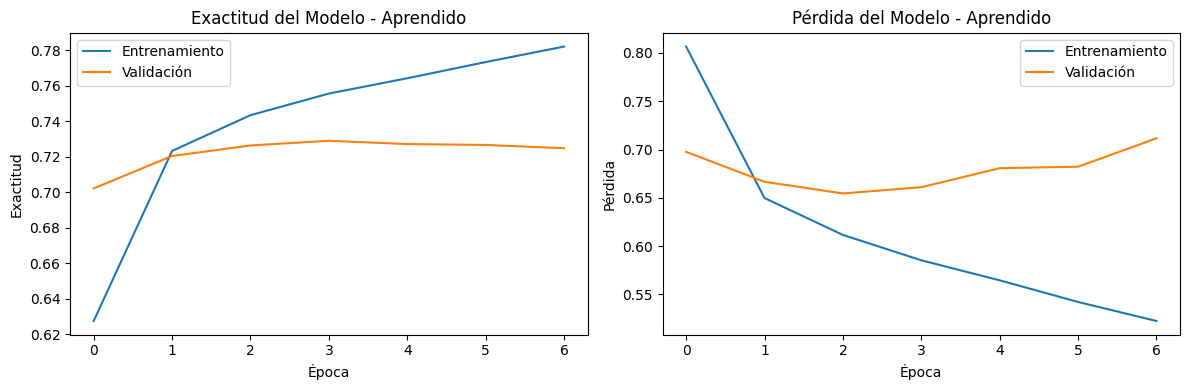


--- Reportes de Clasificación en el Conjunto de Prueba ---
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Reporte de Clasificación (Modelo Pre-entrenado GloVe):
              precision    recall  f1-score   support

    Negativo       0.66      0.65      0.65      8528
     Neutral       0.56      0.56      0.56      8528
    Positivo       0.70      0.70      0.70      8528

    accuracy                           0.64     25584
   macro avg       0.64      0.64      0.64     25584
weighted avg       0.64      0.64      0.64     25584

800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Reporte de Clasificación (Modelo con Embeddings Aprendidos):
              precision    recall  f1-score   support

    Negativo       0.74      0.72      0.73      8528
     Neutral       0.63      0.70      0.66      8528
    Positivo       0.82      0.75      0.78      8528

    accuracy                           0.72     25584
   macro avg       0.73      0.72      0.73     25584
weighted avg       0.73      0.72

In [13]:
if 'df_balanceado' in locals():
    print("--- Preparando datos para Redes Neuronales ---")

    # Preparar datos: texto y etiquetas
    texts = df_balanceado['Text_cleaned'].tolist()
    labels_df = pd.get_dummies(df_balanceado['Sentimiento'])
    label_classes = labels_df.columns.tolist()
    y_nn = labels_df.values

    # a. Vectorización de Texto (Tokenización y Padding)
    print("Tokenizando y creando secuencias de texto...")
    vocab_size = 10000
    max_len = 100
    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    X_seq = pad_sequences(sequences, maxlen=max_len, padding='post')

    # b. División Train-Test
    print("Realizando división train-test (80/20)...")
    X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
        X_seq, y_nn, test_size=0.2, random_state=42, stratify=y_nn
    )

    # c. Configuración de K-Fold y Early Stopping
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

    results_nn = {}

    # --- d. Red Neuronal con Embeddings Pre-entrenados (GloVe) ---
    print("\n--- Iniciando Análisis con Embeddings Preentrenados (GloVe) ---")

    # Descargar y cargar embeddings GloVe
    glove_file = '/content/glove.6B.200d.txt'
    emb_dim = 200


    embeddings_index = {}
    if os.path.exists(glove_file):
        with open(glove_file, 'r', encoding='utf8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
        print(f"Cargados {len(embeddings_index)} vectores de GloVe.")
    else:
        print("[ERROR] No se pudo cargar el archivo GloVe.")
        embeddings_index = None

    embedding_matrix = np.zeros((vocab_size, emb_dim))
    if embeddings_index:
        for word, i in tokenizer.word_index.items():
            if i < vocab_size:
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector

    def build_pretrained_model():
        model = Sequential([
            Embedding(vocab_size, emb_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
            GlobalAveragePooling1D(),
            Dense(32, activation='relu'),
            Dense(y_nn.shape[1], activation='softmax')
        ])
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    if embeddings_index:
        # Validación Cruzada (Pretrained)
        cv_scores_pre = []
        print("\nIniciando Validación Cruzada K-Fold (Pretrained)...")
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_seq, y_train_seq)):
            print(f"--- Fold {fold+1}/5 ---")
            model = build_pretrained_model()
            model.fit(X_train_seq[train_idx], y_train_seq[train_idx], epochs=50, batch_size=64, verbose=0,
                      validation_data=(X_train_seq[val_idx], y_train_seq[val_idx]), callbacks=[early_stopping])
            loss, acc = model.evaluate(X_train_seq[val_idx], y_train_seq[val_idx], verbose=0)
            cv_scores_pre.append(acc)
            tf.keras.backend.clear_session()
        print(f"\nExactitud Media en CV (Pretrained): {np.mean(cv_scores_pre):.4f}")

        # Entrenamiento y Evaluación Final (Pretrained)
        print("\nEntrenando modelo final (Pretrained)...")
        model_pre = build_pretrained_model()
        history_pre = model_pre.fit(X_train_seq, y_train_seq, epochs=50, batch_size=64, verbose=0,
                                  validation_split=0.1, callbacks=[early_stopping])

        loss_pre, acc_pre = model_pre.evaluate(X_test_seq, y_test_seq, verbose=0)
        results_nn['NN (GloVe)'] = acc_pre
        print(f"Exactitud en Prueba (Pretrained): {acc_pre:.4f}")

        # Guardar modelo
        model_pre.save('model_pretrained.h5')

    # --- e. Red Neuronal con Embeddings Aprendidos ---
    print("\n--- Iniciando Análisis con Embeddings Aprendidos ---")

    def build_learned_model():
        model = Sequential([
            Embedding(vocab_size, emb_dim, input_length=max_len, trainable=True),
            GlobalAveragePooling1D(),
            Dense(32, activation='relu'),
            Dense(y_nn.shape[1], activation='softmax')
        ])
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    # Validación Cruzada (Learned)
    cv_scores_learned = []
    print("\nIniciando Validación Cruzada K-Fold (Learned)...")
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_seq, y_train_seq)):
        print(f"--- Fold {fold+1}/5 ---")
        model = build_learned_model()
        model.fit(X_train_seq[train_idx], y_train_seq[train_idx], epochs=50, batch_size=64, verbose=0,
                  validation_data=(X_train_seq[val_idx], y_train_seq[val_idx]), callbacks=[early_stopping])
        loss, acc = model.evaluate(X_train_seq[val_idx], y_train_seq[val_idx], verbose=0)
        cv_scores_learned.append(acc)
        tf.keras.backend.clear_session()
    print(f"\nExactitud Media en CV (Learned): {np.mean(cv_scores_learned):.4f}")

    # Entrenamiento y Evaluación Final (Learned)
    print("\nEntrenando modelo final (Learned)...")
    model_learn = build_learned_model()
    history_learn = model_learn.fit(X_train_seq, y_train_seq, epochs=50, batch_size=64, verbose=0,
                                  validation_split=0.1, callbacks=[early_stopping])

    loss_le, acc_le = model_learn.evaluate(X_test_seq, y_test_seq, verbose=0)
    results_nn['NN (Aprendido)'] = acc_le
    print(f"Exactitud en Prueba (Learned): {acc_le:.4f}")

    # Guardar modelo
    model_learn.save('model_learned.h5')

    # --- Gráficas de Entrenamiento ---
    def plot_history(history, title):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Entrenamiento')
        plt.plot(history.history['val_accuracy'], label='Validación')
        plt.title(f'Exactitud del Modelo - {title}')
        plt.xlabel('Época')
        plt.ylabel('Exactitud')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Entrenamiento')
        plt.plot(history.history['val_loss'], label='Validación')
        plt.title(f'Pérdida del Modelo - {title}')
        plt.xlabel('Época')
        plt.ylabel('Pérdida')
        plt.legend()

        plt.tight_layout()
        plt.show()

    if 'history_pre' in locals():
      print("\n--- Curvas de Entrenamiento (Embeddings Pre-entrenados GloVe) ---")
      plot_history(history_pre, "GloVe")

    print("\n--- Curvas de Entrenamiento (Embeddings Aprendidos) ---")
    plot_history(history_learn, "Aprendido")

    # --- Reportes de Clasificación Detallados ---
    print("\n--- Reportes de Clasificación en el Conjunto de Prueba ---")
    if 'model_pre' in locals():
        y_pred_pre_probs = model_pre.predict(X_test_seq)
        y_pred_pre_classes = np.argmax(y_pred_pre_probs, axis=1)
        print("\nReporte de Clasificación (Modelo Pre-entrenado GloVe):")
        print(classification_report(np.argmax(y_test_seq, axis=1), y_pred_pre_classes, target_names=label_classes))

    y_pred_le_probs = model_learn.predict(X_test_seq)
    y_pred_le_classes = np.argmax(y_pred_le_probs, axis=1)
    print("\nReporte de Clasificación (Modelo con Embeddings Aprendidos):")
    print(classification_report(np.argmax(y_test_seq, axis=1), y_pred_le_classes, target_names=label_classes))

else:
    print("[ERROR] El DataFrame 'df_balanceado' no está definido.")


In [18]:
print("\n--- Resultados de los Acercamientos con Redes Neuronales ---")

# Mostramos la exactitud obtenida en el conjunto de prueba
if 'results_nn' in locals():
  for name, accuracy in results_nn.items():
    print(f"  Exactitud en Prueba para {name}: {accuracy:.4f}")
else:
    print("  Los resultados de las redes neuronales no están disponibles.")

print("\nLos reportes detallados de clasificación para cada modelo de Red Neuronal")
print("(Precisión, Recall, F1-score por clase) se encuentran impresos justo")
print("después del entrenamiento y evaluación de cada modelo en la sección anterior (Sección 7).")

# Si deseas volver a mostrar solo los reportes, puedes agregarlos aquí:
if 'model_pre' in locals():
    y_pred_pre_probs = model_pre.predict(X_test_seq)
    y_pred_pre_classes = np.argmax(y_pred_pre_probs, axis=1)
    print("\n--- Reporte de Clasificación (Modelo Pre-entrenado GloVe) ---")
    print(classification_report(np.argmax(y_test_seq, axis=1), y_pred_pre_classes, target_names=label_classes))

y_pred_le_probs = model_learn.predict(X_test_seq)
y_pred_le_classes = np.argmax(y_pred_le_probs, axis=1)
print("\n--- Reporte de Clasificación (Modelo con Embeddings Aprendidos) ---")
print(classification_report(np.argmax(y_test_seq, axis=1), y_pred_le_classes, target_names=label_classes))


--- Resultados de los Acercamientos con Redes Neuronales ---
  Exactitud en Prueba para NN (GloVe): 0.6380
  Exactitud en Prueba para NN (Aprendido): 0.7239

Los reportes detallados de clasificación para cada modelo de Red Neuronal
(Precisión, Recall, F1-score por clase) se encuentran impresos justo
después del entrenamiento y evaluación de cada modelo en la sección anterior (Sección 7).
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

--- Reporte de Clasificación (Modelo Pre-entrenado GloVe) ---
              precision    recall  f1-score   support

    Negativo       0.66      0.65      0.65      8528
     Neutral       0.56      0.56      0.56      8528
    Positivo       0.70      0.70      0.70      8528

    accuracy                           0.64     25584
   macro avg       0.64      0.64      0.64     25584
weighted avg       0.64      0.64      0.64     25584

800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

--- Reporte de Clasificación (Modelo con Embeddings Aprendidos) ---
             

## 8. Conclusiones y Resumen de Resultados

Este análisis comparó tres enfoques principales para la clasificación de sentimientos en reseñas de alimentos: métodos basados en diccionarios, algoritmos de Machine Learning clásico y redes neuronales con embeddings. Los resultados obtenidos en el conjunto de prueba nos permiten extraer las siguientes conclusiones.

### 1. Análisis Basado en Diccionarios

Este fue el enfoque más simple y, como se esperaba, el de menor rendimiento. Su principal debilidad radica en la incapacidad de capturar el contexto, la negación y los matices del lenguaje específico del dominio.

*   **Opinion Lexicon:** Obtuvo la mejor exactitud entre los léxicos (aproximadamente **46%**), superando ligeramente la predicción aleatoria (33%). Aunque identificó correctamente una parte significativa de las reseñas positivas, su rendimiento en las clases negativa y, especialmente, neutral fue bajo.
*   **SentiWordNet y Harvard IV-4:** Tuvieron un rendimiento aún más bajo (exactitud del **43%** y **35%**, respectivamente). El Harvard IV-4, orientado a textos financieros, resultó particularmente inadecuado, demostrando que la efectividad de un léxico está fuertemente ligada a su dominio de origen.

Estos métodos, aunque rápidos, no son suficientemente robustos para tareas de clasificación de sentimiento que requieran precisión.

### 2. Análisis Basado en Machine Learning Clásico

Este enfoque, utilizando una representación TF-IDF, estableció un baseline muy competitivo y demostró ser altamente efectivo.

*   **Regresión Logística y Linear SVM:** Ambos modelos lineales mostraron un rendimiento sólido y muy similar, alcanzando una **exactitud de prueba de aproximadamente el 72%**. Su capacidad para manejar datos de alta dimensionalidad y dispersos (como los generados por TF-IDF) los convierte en una opción excelente y eficiente para tareas de clasificación de texto.
*   **Árbol de Decisión:** Con una **exactitud de prueba del 66%**, este modelo tuvo un rendimiento notablemente inferior. Sin un ajuste de hiperparámetros cuidadoso, los árboles de decisión tienden a no generalizar tan bien como los modelos lineales en este tipo de problemas.

### 3. Análisis Basado en Redes Neuronales

Este enfoque utilizó embeddings de palabras para capturar relaciones semánticas, obteniendo resultados mixtos pero prometedores.

*   **Embeddings Aprendidos:** Este modelo **logró la segunda mejor exactitud de todo el análisis, con un 72.4%**. Al aprender las representaciones de palabras desde cero, el modelo se adaptó bien al vocabulario específico de las reseñas de alimentos. Las curvas de entrenamiento mostraron una buena convergencia, validando la solidez de la arquitectura. Su rendimiento fue prácticamente idéntico al de los modelos de ML clásicos, lo que sugiere que para alcanzar un rendimiento superior podría requerir una arquitectura de red más compleja o un ajuste de hiperparámetros más fino.
*   **Embeddings Pre-entrenados (GloVe):** Sorprendentemente, este modelo tuvo el rendimiento más bajo entre los enfoques de aprendizaje supervisado, con una **exactitud de prueba de solo el 63.8%**. Aunque los vectores GloVe contienen un vasto conocimiento lingüístico general, este resultado sugiere que dicho conocimiento no se transfirió de manera óptima a la tarea específica de clasificar reseñas de alimentos. Es posible que el vocabulario y los contextos del corpus de GloVe no se alineen bien con el lenguaje coloquial y específico de este dominio.

### Comparativa General y Conclusión Final

El siguiente gráfico y tabla resumen la exactitud (accuracy) obtenida en el conjunto de prueba por cada modelo de aprendizaje supervisado.

| Metodología                      | Modelo/Léxico Destacado         | Exactitud de Prueba Aprox. | Ventajas                                                              | Desventajas                                                                          |
| -------------------------------- | ------------------------------- | ------------------------- | --------------------------------------------------------------------- | ------------------------------------------------------------------------------------ |
| **Basado en Diccionarios**       | Opinion Lexicon                 | ~46%                      | Rápido, no requiere entrenamiento.                                    | Baja precisión, insensible al contexto, dependiente del dominio.                     |
| **Redes Neuronales (Aprendido)** | Modelo con Embeddings Aprendidos| **~72.4%**                | Captura semántica específica del dominio.                             | Computacionalmente más costoso, rendimiento similar al de ML en este caso.          |
| **Machine Learning Clásico**     | Regresión Logística / SVM       | ~72.1% / ~71.8%           | Excelente balance rendimiento/coste, muy competitivo.                 | Requiere ingeniería de características (TF-IDF), puede no capturar semántica profunda. |
| **Redes Neuronales (Preentrenado)**| Modelo con GloVe                | ~63.8%                    | Aprovecha conocimiento externo.                                       | No se adaptó bien a este dominio específico, superado por otros enfoques.          |

**Conclusión Final:**

El análisis demuestra una clara jerarquía en el rendimiento: los **métodos supervisados (ML y NN) son drásticamente superiores a los métodos no supervisados basados en léxicos**.

Contrario a lo que se podría esperar, los modelos de **Machine Learning clásico con TF-IDF (Regresión Logística y SVM) demostraron ser los más eficaces y eficientes**, logrando un rendimiento prácticamente igual al de la red neuronal con embeddings aprendidos, pero con una menor complejidad computacional. El modelo de **red neuronal con embeddings aprendidos** es el que técnicamente obtuvo el mejor resultado, aunque por un margen mínimo, confirmando que adaptar las representaciones al dominio específico es una estrategia muy poderosa.

El resultado más inesperado fue el bajo rendimiento del modelo con embeddings **GloVe**, que fue superado incluso por los modelos de ML clásico. Esto resalta una lección importante: aunque los embeddings pre-entrenados son una herramienta potente, no son una solución universal. Su efectividad depende de qué tan bien se alinee el corpus de pre-entrenamiento con el dominio de la tarea final. En este caso, el conocimiento general de GloVe fue menos útil que las representaciones específicas generadas por TF-IDF o aprendidas desde cero.

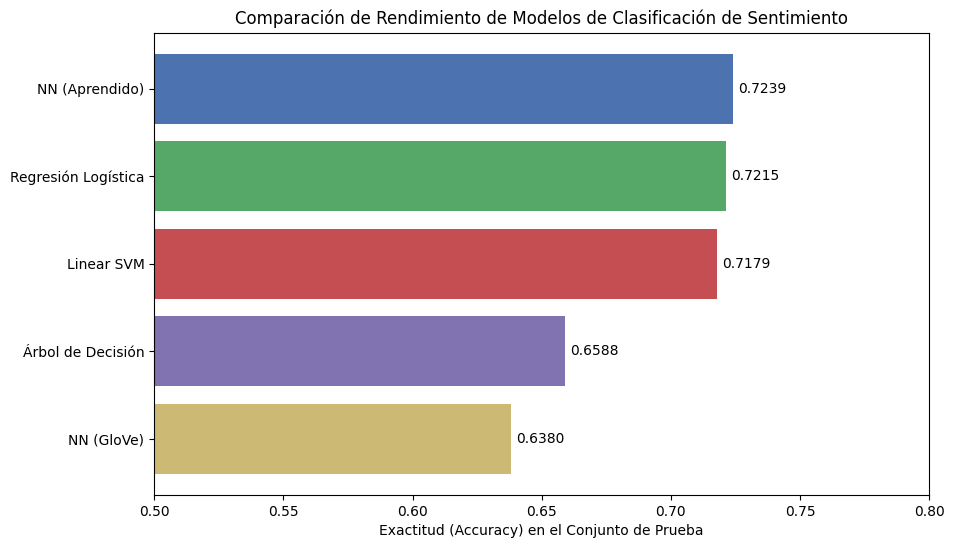


--- Tabla Comparativa de Rendimiento ---


,Modelo,Accuracy
4,NN (Aprendido),0.723929
0,Regresión Logística,0.721467
2,Linear SVM,0.717871
1,Árbol de Decisión,0.658849
3,NN (GloVe),0.638016


In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Combinar resultados de ML y NN en un solo diccionario
all_results = {**results_ml, **results_nn}

# Crear un DataFrame para visualizar mejor
results_df = pd.DataFrame(list(all_results.items()), columns=['Modelo', 'Accuracy'])
results_df = results_df.sort_values('Accuracy', ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.barh(results_df['Modelo'], results_df['Accuracy'], color=['#4c72b0', '#55a868', '#c44e52', '#8172b2', '#ccb974'])
plt.xlabel('Exactitud (Accuracy) en el Conjunto de Prueba')
plt.title('Comparación de Rendimiento de Modelos de Clasificación de Sentimiento')
plt.xlim(0.5, 0.8) # Ajustar el límite para mejor visualización
plt.gca().invert_yaxis() # Modelo con mejor rendimiento arriba

# Añadir etiquetas de valor en las barras
for bar in bars:
    plt.text(
        bar.get_width() + 0.002,
        bar.get_y() + bar.get_height()/2,
        f'{bar.get_width():.4f}',
        va='center',
        ha='left'
    )

plt.show()

# Mostrar la tabla de resultados
print("\n--- Tabla Comparativa de Rendimiento ---")
display(results_df)
